In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

from dataloader import *
from model import *
from util_sample import *
import os.path
import math

### Load data:

In [2]:
directory = 'data/'
filename = 'coords_80.csv'
config = {}
config['seq_len'] = 79
config['batch_size'] = 20
config['overlap_rate'] = 0.0
config['coords'] = 3
config['mixtures'] = 2

dl = DataLoad(directory, filename)
dl.load_data(config['seq_len'], config['overlap_rate'], augment = True, verbose = False)
dl.split_train_test(0.8)

data = dl.data
X_test = np.transpose(data['X_test'], [0,2,1])
X_test_raw = np.transpose(data['X_test_raw'], [0,2,1])

max z is 459
31998 train samples and 8000 test samples


### Display some test data:

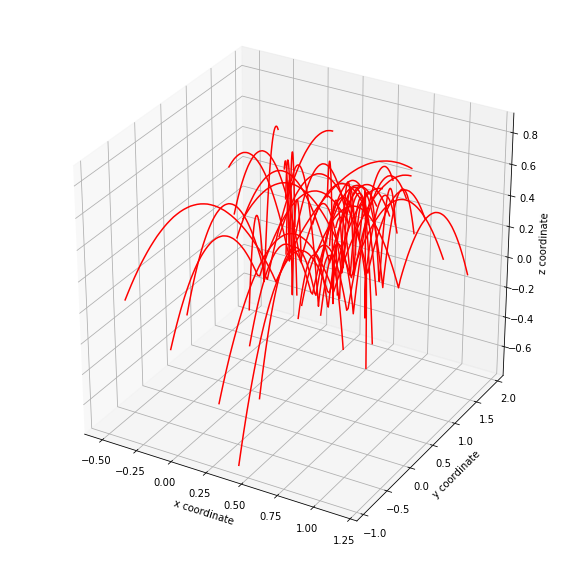

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(30):
    seq = X_test_raw[i]
    ax.plot(seq[0,:], seq[1,:], seq[2,:],'r')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
plt.show()

### Load the pretrain model:

In [5]:
g = tf.Graph()
pretrained_graph_def = tf.GraphDef()
pretrained_graph_path = './data/export-graph_80.pb'

with open(pretrained_graph_path, 'rb') as f:
    pretrained_graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(pretrained_graph_def, name='')

Load some ops in the graph:

In [6]:
session = tf.Session()

placeholder_x = session.graph.get_tensor_by_name("Test/Model/Input_data:0")
initial_state_c_0 = session.graph.get_tensor_by_name("Test/Model/zeros:0")
initial_state_h_0 = session.graph.get_tensor_by_name("Test/Model/zeros_1:0")
initial_state_c_1 = session.graph.get_tensor_by_name("Test/Model/zeros_2:0")
initial_state_h_1 = session.graph.get_tensor_by_name("Test/Model/zeros_3:0")
initial_state = []
initial_state.append((initial_state_c_0, initial_state_h_0))
initial_state.append((initial_state_c_1, initial_state_h_1))
final_state_c_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/add_3:0")
final_state_h_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_0/lstm_cell/mul_5:0")
final_state_c_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_1/lstm_cell/add_3:0")
final_state_h_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell/cell_1/lstm_cell/mul_5:0")
final_state = []
final_state.append((final_state_c_0, final_state_h_0))
final_state.append((final_state_c_1, final_state_h_1))
test_outputs = []
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:1"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:2"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_2:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_3:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Tanh:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Mul:0"))

### Sample some sequence with our model:

some parameters:

- predict_len: length of the sequence the model has to predict.
- sl_pre: number of data points you feed to the model before it predict.
- bias: a large bias will make the predicted trajectory less diversity.

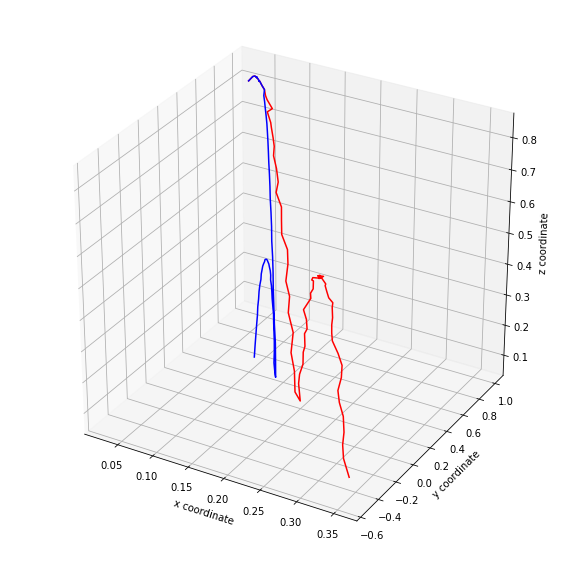

In [14]:
seq_pred = sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[5][:], predict_len=70, sl_pre=10, bias=2.0, display=True)

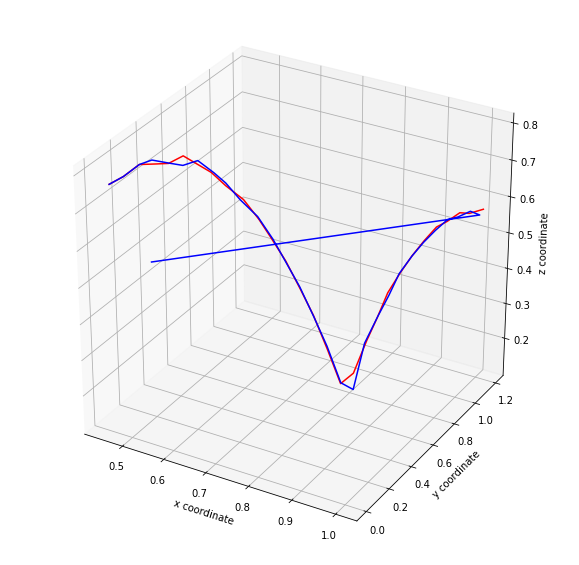

In [20]:
seq_pred = sample_next(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], sl_pre = 2, bias=10.0, display=True)

### Predict with less data points fed:

In [13]:
def find_landing_point(seq):
    #[3,seq_len]
    for i in range(1,seq.shape[1]-1):
        if seq[2,i+1]>seq[2,i] and seq[2,i-1]>seq[2,i]:
            return seq[:,i]
    return None

In [14]:
print find_landing_point(X_test_raw[3])
print seq_pred[0,:,-2]

[ 0.57107869  0.16395985  0.08981539]
[ 0.36019579 -0.28654404  0.37640412]


In [15]:
def distance(pt1, pt2):
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

def distance_3d(pt1, pt2):
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2+(pt1[2]-pt2[2])**2)

def to_world(pt):
    return [pt[0]*1525, pt[1]*2740, pt[2]*458]

In [16]:
distance(to_world(seq_pred[0,:,-2]), to_world(find_landing_point(X_test_raw[0])))

2844.4956794615614

In [17]:
diff = np.transpose(X_test_raw[0,:,10:] - seq_pred[0,:,10:-1], (1,0))
d = 0
for i in range(diff.shape[0]):
    d += distance_3d(to_world(diff[i]), [0,0,0])
print d/110

ValueError: operands could not be broadcast together with shapes (3,110) (3,109) 

### landing point prediction

0 / 2000


/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/jing/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


500 / 2000
1000 / 2000
1500 / 2000
114.987474994


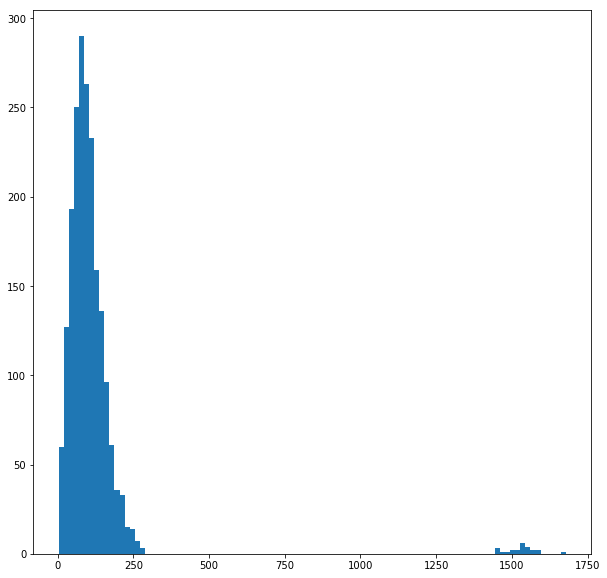

In [18]:
N = X_test.shape[0]/4
dist = 0
dists = []
valid = 0
for i in range(N):
    if i%500==0:
        print i,'/',N
    seq_pred = sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test_raw[i], predict_len=120, sl_pre=30, bias=20.0, sample_until_landing=True)
    if seq_pred == None:
        continue
    pt1 = seq_pred[0,:,-2]
    pt2 = find_landing_point(X_test_raw[i])
    if pt2 == None:
        continue
    d = distance(to_world(pt1), to_world(pt2))
    #if d>100:
    #    print i, d
    dist += d
    dists.append(d)
    valid += 1
print dist/valid
_ = plt.hist(dists, bins=100)

### next point prediction

0 / 1000
500 / 1000
0.725972450669


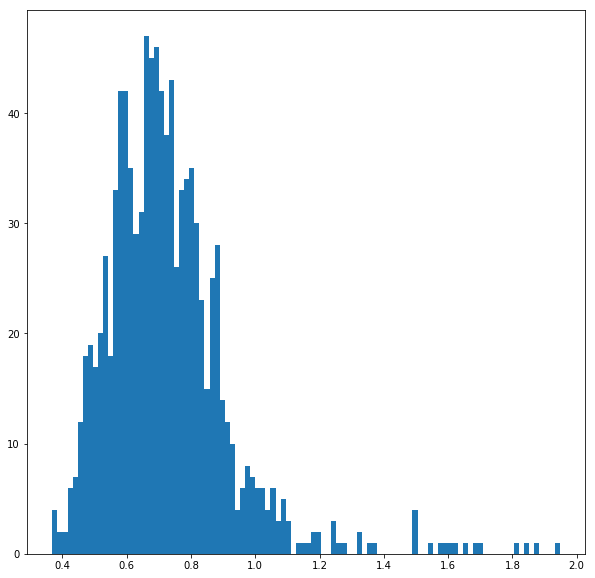

In [45]:
N = X_test.shape[0]/4
dist = 0
dists = []
valid = 0
sl_pre = 4
for i in range(N):
    if i%500==0:
        print i,'/',N
    seq_pred = sample_next(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test_raw[i], sl_pre=sl_pre, bias=20.0)
    d = 0
    for j in range(sl_pre, X_test.shape[2]):
        d += distance_3d(to_world(X_test_raw[i,:,j]), to_world(seq_pred[0,:,j]))
    dist += d/(X_test.shape[2]-sl_pre)
    dists.append(d/(X_test.shape[2]-sl_pre))
    valid += 1
print dist/valid
_ = plt.hist(dists, bins=100)

### MDN diagnose

-0.0146737135947 0.0721174776554
0.0119307469577 0.0126946913078


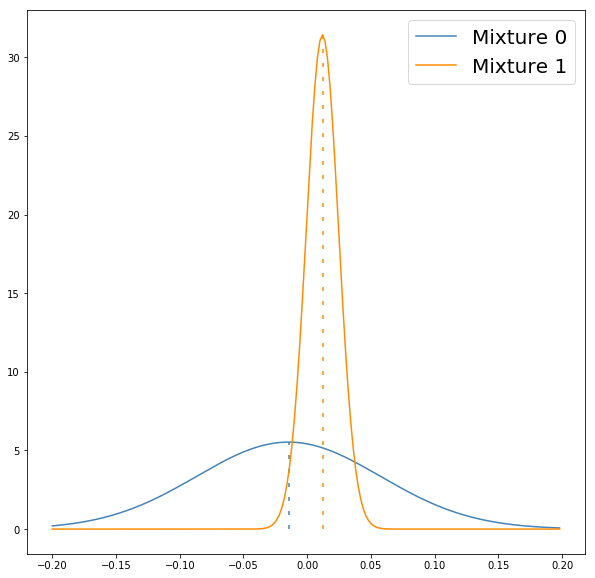

In [47]:
seq_pred, gaussian_z, draw_z = sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], predict_len=120, sl_pre=30, bias=2.0, display=False, output_gaussian=True)

idx = 0#landing point
for i in range(1,seq.shape[1]-1):
    #print i,gaussian_z[:2,i], draw_z[0,i], seq[2,i]
    if seq[2,i+1]>seq[2,i] and seq[2,i-1]>seq[2,i]:
        idx = i
        #print "landing! ",idx

gaussian = gaussian_z[:,63]

def gd(x, mean, std, theta):
    left = theta/(math.sqrt(2*math.pi)*std)
    right = np.exp(-(x-mean)**2/(2*std**2))
    return left*right
    
x = np.arange(-0.2,0.2,0.002)
fig, ax = plt.subplots()
color = ['steelblue', 'darkorange', 'red']
for i in range(config['mixtures']):
    print gaussian[i], gaussian[config['mixtures']+i]
    y = gd(x, gaussian[i], gaussian[config['mixtures']+i], 1)#gaussian[config['mixtures']*2+i]
    max_idx = np.argmax(y)
    X, Y = np.ones(10)*x[max_idx], np.linspace(0,y[max_idx],10)
    ax.plot(X,Y,linestyle=(0,(2,5)),color=color[i])
    #y = gd(x,0,0.1,1)
    #print x.shape, y.shape
    ax.plot(x,y,label='Mixture '+str(i),color=color[i])
ax.legend(loc='upper right', fontsize=20)